In [3]:
import numpy as np
import pandas as pd
from vnstock import Vnstock
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.optimize import minimize
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import gaussian_kde
from scipy.stats import beta, dirichlet, norm, invwishart, invgamma, beta
from scipy.special import gammaln, gamma
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import time
from datetime import datetime
from scipy import stats


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/vnai/scope/profile.py:742: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Phiên bản Vnstock 3.2.6 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.5

# 0. OVERVIEW

In [ ]:
# Stock list
ASSETS = ["HPG", "VCB", "CTG", "MSN", "MWG"]

# Create 4 periods
date_ranges = {
    "2012_2015": ("2012-01-01", "2015-12-31"),
    "2016_2019": ("2016-01-01", "2019-12-31"),
    "2020_2021": ("2020-01-01", "2021-12-31"),
    "2022_2024": ("2022-01-01", "2024-12-31")
}

# Create dict to save data in each period
data_periods = {}

# Looping each period
for label, (start_date, end_date) in date_ranges.items():
    print(f"\n=== Loading data for {label} ({start_date} to {end_date}) ===")
    
    data = pd.DataFrame()
    
    # Download data 
    for ticker in ASSETS:
        print(f"Downloading {ticker}...")
        stock = Vnstock().stock(symbol=ticker, source="VCI")
        df = stock.quote.history(start=start_date, end=end_date)
        df = df[["time", "close"]].rename(columns={"close": ticker})
        
        if data.empty:
            data = df.copy()
        else:
            data = pd.merge(data, df, on="time", how="outer")
    
    # set index
    data["time"] = pd.to_datetime(data["time"])
    data = data.sort_values("time").set_index("time")
    
    # Save to dict
    data_periods[label] = data

# Checking results
for key, df in data_periods.items():
    print(f"\n>>> {key}: {df.shape} rows")
    print(df.head())



=== Loading data for 2012_2015 (2012-01-01 to 2015-12-31) ===

=== Loading data for 2016_2019 (2016-01-01 to 2019-12-31) ===

=== Loading data for 2020_2021 (2020-01-01 to 2021-12-31) ===



=== Loading data for 2022_2024 (2022-01-01 to 2024-12-31) ===

>>> 2012_2015: (995, 5) rows
             HPG   VCB   CTG    MSN  MWG
time                                    
2012-01-03  0.66  4.75  6.26  45.55  NaN
2012-01-04  0.64  4.63  6.55  45.55  NaN
2012-01-05  0.62  4.61  6.52  44.52  NaN
2012-01-06  0.60  4.52  6.63  42.47  NaN
2012-01-09  0.60  4.66  6.66  42.98  NaN

>>> 2016_2019: (1001, 5) rows
             HPG    VCB    CTG    MSN   MWG
time                                       
2016-01-04  2.87  13.07  11.29  38.86  8.94
2016-01-05  2.84  12.86  11.17  38.61  8.94
2016-01-06  2.89  13.01  11.29  39.12  8.88
2016-01-07  2.81  12.86  11.17  39.89  8.60
2016-01-08  2.76  12.77  10.92  39.38  8.49

>>> 2020_2021: (502, 5) rows
             HPG    VCB    CTG    MSN    MWG
time                                        
2020-01-02  8.28  39.49  14.35  46.12  37.43
2020-01-03  8.33  39.10  14.21  46.53  36.89
2020-01-06  8.28  38.06  14.25  45.80  36.70
2020-01-07  8.17  38.19  1

In [5]:
data_12_15 = data_periods["2012_2015"]
daily_log_returns_12_15 = np.log(data_12_15).diff().dropna()
observed_12_15_daily_returns = daily_log_returns_12_15.values

data_16_19 = data_periods["2016_2019"]
daily_log_returns_16_19 = np.log(data_16_19).diff().dropna()
observed_16_19_daily_returns = daily_log_returns_16_19.values

data_20_21 = data_periods["2020_2021"]
daily_log_returns_20_21 = np.log(data_20_21).diff().dropna()
observed_20_21_daily_returns = daily_log_returns_20_21.values

data_22_24 = data_periods["2022_2024"]
daily_log_returns_22_24 = np.log(data_22_24).diff().dropna()
observed_22_24_daily_returns = daily_log_returns_22_24.values


In [6]:
RISK_FREE_RATE = 0.03

# Gibbs Sampling 

In [7]:
from scipy.stats import invwishart, multivariate_normal

def run_gibbs_sampling(daily_log_returns, 
                       kappa_0=1,
                       nu_extra=2,
                       n_iter=20000,
                       RISK_FREE_RATE=0.03,
                       verbose=True):
    """
    Gibbs Sampling Portfolio Optimization for a specific period.
    """
    T, N = daily_log_returns.shape
    returns = daily_log_returns.values

    # === 1. Prior hyperparameters ===
    mu_0 = returns.mean(axis=0) * 252
    psi_0 = np.cov(returns.T) * 252
    nu_0 = N + nu_extra

    # === 2. Initialize storage ===
    samples_mu = np.zeros((n_iter, N))
    samples_cov = np.zeros((n_iter, N, N))

    if verbose:
        print(f"Running Gibbs Sampling: kappa_0={kappa_0}, nu_0={nu_0}, n_iter={n_iter}")

    # === 3. Gibbs Sampling Loop ===
    for i in range(n_iter):
        # Sample Sigma | mu, R
        r_bar = np.mean(returns, axis=0)
        S = (returns - r_bar).T @ (returns - r_bar)
        psi_n = psi_0 + S + (kappa_0 * T / (kappa_0 + T)) * np.outer(r_bar - mu_0, r_bar - mu_0)
        nu_n = nu_0 + T
        cov = invwishart.rvs(df=nu_n, scale=psi_n)

        # Sample mu | Sigma, R
        kappa_n = kappa_0 + T
        mu_n = (kappa_0 * mu_0 + T * r_bar) / kappa_n
        mu_cov = cov / kappa_n
        mu = multivariate_normal.rvs(mean=mu_n, cov=mu_cov)

        samples_mu[i] = mu * 252  # annualized
        samples_cov[i] = cov * 252

    # === 4. Optimization (Markowitz Sharpe Ratio) ===
    n_samples = n_iter
    bounds = tuple((0, 1) for _ in range(N))
    constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
    initial_guess = np.repeat(1/N, N)

    results = {
        "weights": [],
        "return": [],
        "volatility": [],
        "sharpe": [],
    }

    def negative_sharpe(weights, mean_returns, cov_matrix):
        ret = np.sum(weights * mean_returns)
        vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(ret - RISK_FREE_RATE) / vol

    if verbose:
        print("Optimizing Sharpe Ratio across samples...")

    for i in range(n_samples):
        mu_i = samples_mu[i]
        cov_i = samples_cov[i]

        res = minimize(
            negative_sharpe,
            initial_guess,
            args=(mu_i, cov_i),
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
        )

        if res.success:
            w_opt = res.x
            ret_opt = np.sum(w_opt * mu_i)
            vol_opt = np.sqrt(np.dot(w_opt.T, np.dot(cov_i, w_opt)))
            sharpe_opt = (ret_opt - RISK_FREE_RATE) / vol_opt
            results["weights"].append(w_opt)
            results["return"].append(ret_opt)
            results["volatility"].append(vol_opt)
            results["sharpe"].append(sharpe_opt)
        else:
            results["weights"].append(np.full(N, np.nan))
            results["return"].append(np.nan)
            results["volatility"].append(np.nan)
            results["sharpe"].append(np.nan)

    # === 5. Convert and summarize
    returns_array = np.array(results["return"])
    vols_array = np.array(results["volatility"])
    sharpes_array = np.array(results["sharpe"])
    weights_array = np.array(results["weights"])

    mean_return = np.nanmean(returns_array)
    mean_vol = np.nanmean(vols_array)
    mean_sharpe = np.nanmean(sharpes_array)
    mean_weights = np.nanmean(weights_array, axis=0)

    # === 6. Print summary
    print("\n=== Mean Optimized Portfolio across Gibbs Samples ===")
    print(f"Expected Return: {mean_return*100:.2f}%")
    print(f"Volatility:      {mean_vol*100:.2f}%")
    print(f"Sharpe Ratio:    {mean_sharpe:.3f}")
    print("\nMean Weights:")
    for asset, w in zip(ASSETS, mean_weights):
        print(f"  {asset}: {w:.4f} ({w*100:.1f}%)")

    return {
        "returns": returns_array,
        "volatility": vols_array,
        "sharpe": sharpes_array,
        "weights": weights_array,
        "mean_return": mean_return,
        "mean_vol": mean_vol,
        "mean_sharpe": mean_sharpe,
        "mean_weights": mean_weights,
        "samples_mu": samples_mu,
        "samples_cov": samples_cov,
    }


In [8]:
# 2012-2015
res_12_15 = run_gibbs_sampling(daily_log_returns_12_15)

# 2016-2019
res_16_19 = run_gibbs_sampling(daily_log_returns_16_19)

# 2020-2021
res_20_21 = run_gibbs_sampling(daily_log_returns_20_21)

# 2022-2024
res_22_24 = run_gibbs_sampling(daily_log_returns_22_24)


Running Gibbs Sampling: kappa_0=1, nu_0=7, n_iter=20000
Optimizing Sharpe Ratio across samples...

=== Mean Optimized Portfolio across Gibbs Samples ===
Expected Return: 83.38%
Volatility:      47.16%
Sharpe Ratio:    1.724

Mean Weights:
  HPG: 0.0390 (3.9%)
  VCB: 0.3326 (33.3%)
  CTG: 0.1633 (16.3%)
  MSN: 0.0680 (6.8%)
  MWG: 0.3972 (39.7%)
Running Gibbs Sampling: kappa_0=1, nu_0=7, n_iter=20000
Optimizing Sharpe Ratio across samples...

=== Mean Optimized Portfolio across Gibbs Samples ===
Expected Return: 46.55%
Volatility:      31.75%
Sharpe Ratio:    1.380

Mean Weights:
  HPG: 0.2099 (21.0%)
  VCB: 0.2744 (27.4%)
  CTG: 0.0115 (1.2%)
  MSN: 0.0486 (4.9%)
  MWG: 0.4556 (45.6%)
Running Gibbs Sampling: kappa_0=1, nu_0=7, n_iter=20000
Optimizing Sharpe Ratio across samples...

=== Mean Optimized Portfolio across Gibbs Samples ===
Expected Return: 94.74%
Volatility:      52.54%
Sharpe Ratio:    1.753

Mean Weights:
  HPG: 0.3489 (34.9%)
  VCB: 0.0431 (4.3%)
  CTG: 0.1300 (13.0%)
  

In [13]:
gibbs_results = {
    "2012_2015": res_12_15,
    "2016_2019": res_16_19,
    "2020_2021": res_20_21,
    "2022_2024": res_22_24,
}

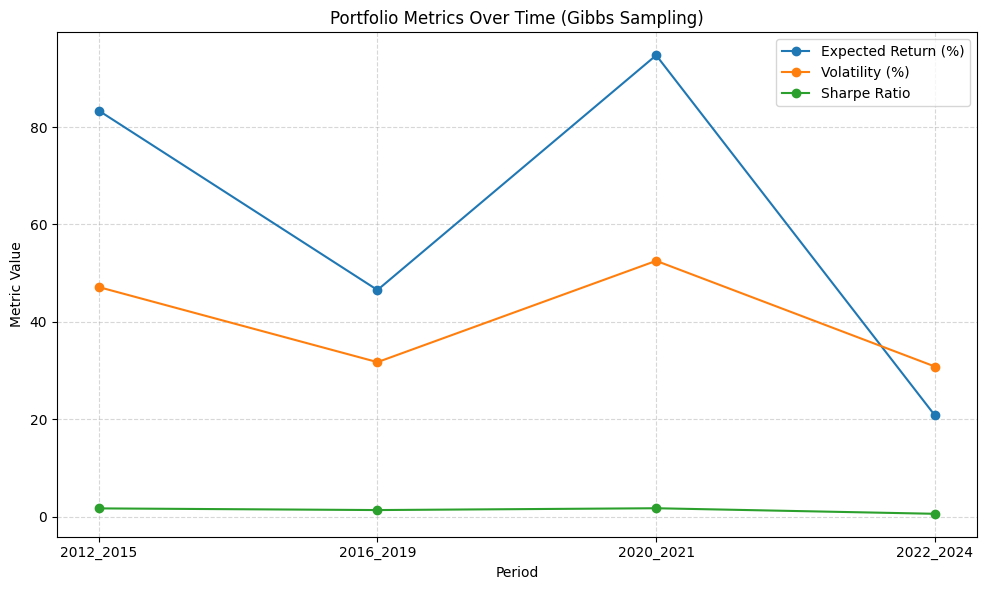

In [14]:
# Define period labels
period_labels = list(gibbs_results.keys())

# Extract metrics
mean_returns = [gibbs_results[p]["mean_return"]*100 for p in period_labels]
mean_vols = [gibbs_results[p]["mean_vol"]*100 for p in period_labels]
mean_sharpes = [gibbs_results[p]["mean_sharpe"] for p in period_labels]

# Line Plot
plt.figure(figsize=(10,6))
plt.plot(period_labels, mean_returns, marker="o", label="Expected Return (%)")
plt.plot(period_labels, mean_vols, marker="o", label="Volatility (%)")
plt.plot(period_labels, mean_sharpes, marker="o", label="Sharpe Ratio")

plt.title("Portfolio Metrics Over Time (Gibbs Sampling)")
plt.xlabel("Period")
plt.ylabel("Metric Value")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


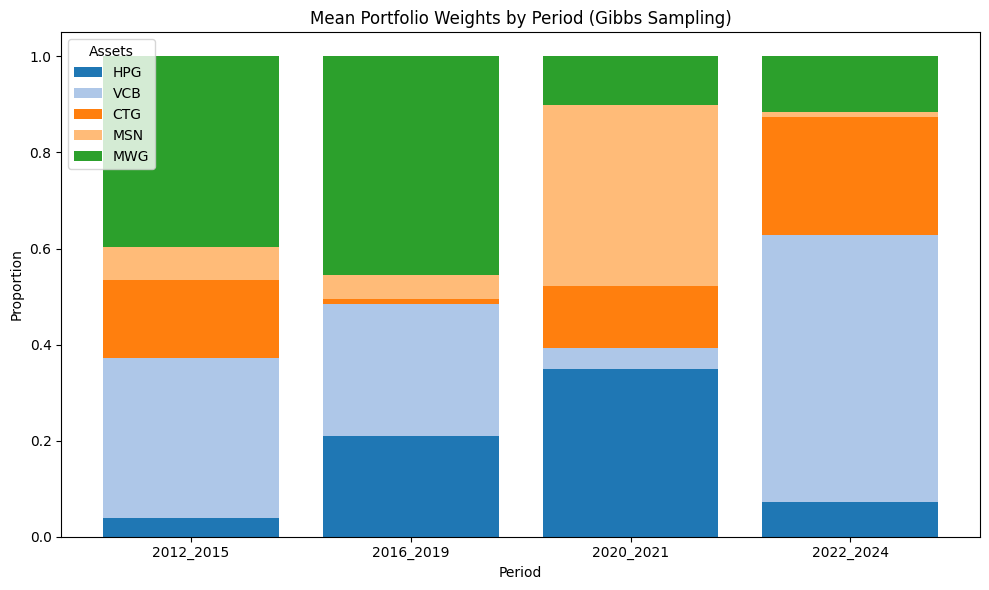


## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [Sổ tay hướng dẫn](https://vnstocks.com/docs/category/s%E1%BB%95-tay-h%C6%B0%E1%BB%9Bng-d%E1%BA%ABn)
* Cộng đồng: [Nhóm Facebook](https://www.facebook.com/groups/vnstock.official)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
                


## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [Sổ tay hướng dẫn](https://vnstocks.com/docs/category/s%E1%BB%95-tay-h%C6%B0%E1%BB%9Bng-d%E1%BA%ABn)
* Cộng đồng: [Nhóm Facebook](https://www.facebook.com/groups/vnstock.official)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
                

In [15]:
# Collect mean weights for each period
mean_weights = np.array([gibbs_results[p]["mean_weights"] for p in period_labels])

# Prepare figure
fig, ax = plt.subplots(figsize=(10,6))

# Bottoms for stacking
bottom = np.zeros(len(period_labels))

# Colors
colors = plt.cm.tab20.colors

# Stack bars
for i, asset in enumerate(ASSETS):
    ax.bar(
        period_labels,
        mean_weights[:, i],
        bottom=bottom,
        label=asset,
        color=colors[i % len(colors)]
    )
    bottom += mean_weights[:, i]

# Formatting
ax.set_title("Mean Portfolio Weights by Period (Gibbs Sampling)")
ax.set_ylabel("Proportion")
ax.set_xlabel("Period")
ax.legend(title="Assets")
plt.tight_layout()
plt.show()
